In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=21, padding=10)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=15, padding=7)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, padding=5)
        
        self.batchnorm32 = nn.BatchNorm1d(num_features=32)
        self.batchnorm64 = nn.BatchNorm1d(num_features=64)
        self.batchnorm128 = nn.BatchNorm1d(num_features=128)
        self.batchnorm512 = nn.BatchNorm1d(num_features=512)
        
        self.fc1 = nn.Linear(4736, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchnorm32(x))
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = F.relu(self.batchnorm64(x))
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = F.relu(self.batchnorm128(x))
        x = self.maxpool(x)
        
        # Flatten input for fully connected layers
        x = x.view(x.shape[0], -1) 
        
        x = self.fc1(x)
        x = F.relu(self.batchnorm512(x))
        
        x = self.fc2(x)
        x = F.relu(self.batchnorm512(x))
        
        x = self.fc3(x)
        
        return x

In [10]:
model = CNN()

In [13]:
def parallelize(model):
    device_ids = [i for i in range(torch.cuda.device_count())]
    model = torch.nn.DataParallel(model, device_ids=device_ids)
    return model

In [14]:
model = parallelize(model)

In [134]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

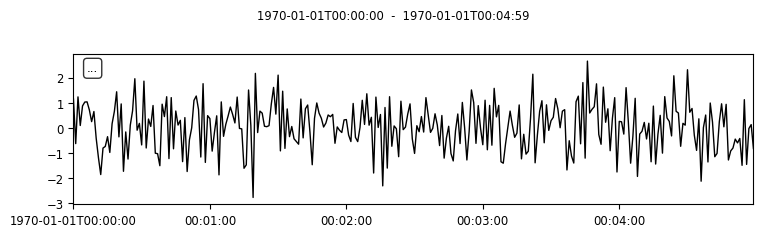

In [85]:
from obspy.core.trace import Trace

input_wave = Trace(in_tensor.squeeze().numpy())
input_wave.plot()

C:\Users\rober\Miniconda3\lib\site-packages\matplotlib\dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  ' Defaulting to {0}.'.format(interval))


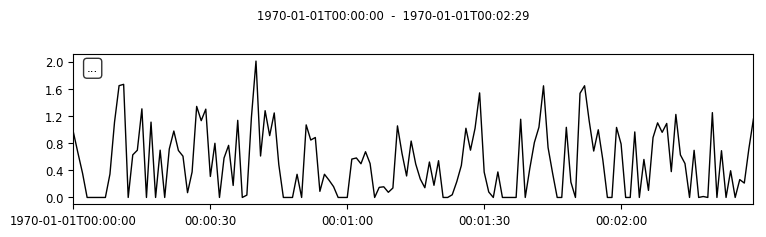

In [89]:
wave1 = Trace(output[0][0][0].detach().squeeze().numpy())
wave1.plot()

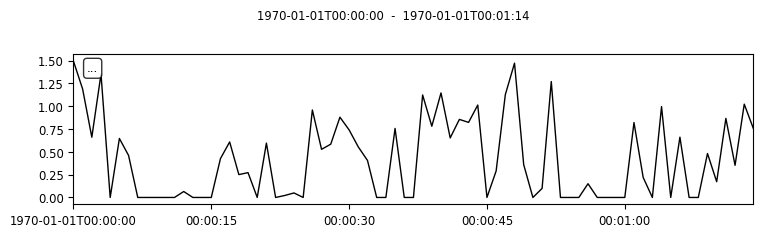

In [90]:
wave2 = Trace(output[1][0][0].detach().squeeze().numpy())
wave2.plot()

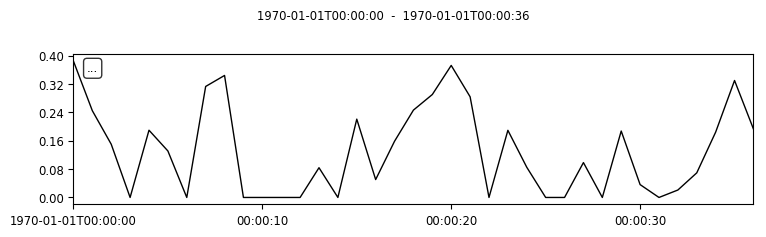

In [91]:
wave3 = Trace(output[2][0][0].detach().squeeze().numpy())
wave3.plot()